In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import glob
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.tseries.offsets import DateOffset

In [49]:
E:\\Capstone\\Concate_files\\East_virginia_Richmond_concat.csv

['E:\\Capstone\\Concate_files\\East_virginia_Richmond_concat.csv',
 'E:\\Capstone\\Concate_files\\North_New Jersey_Trenton_concat.csv',
 'E:\\Capstone\\Concate_files\\South_texas_Austin_concat.csv',
 'E:\\Capstone\\Concate_files\\West_California_Sacramento_concat.csv']

ADF Test Statistic : -8.85684820602518
p-value : 1.5197640264267964e-14
#Lags Used : 5
Number of Observations Used : 54
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
ADF Test Statistic : -3.8558553955184096
p-value : 0.002384846875334316
#Lags Used : 8
Number of Observations Used : 39
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\shiva\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ADF Test Statistic : -1.7273612226132509
p-value : 0.41707313264783885
#Lags Used : 11
Number of Observations Used : 48
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
ADF Test Statistic : -5.6236295016710915
p-value : 1.1303122400141202e-06
#Lags Used : 0
Number of Observations Used : 47
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\shiva\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ADF Test Statistic : -6.263269278838133
p-value : 4.1729389920276155e-08
#Lags Used : 6
Number of Observations Used : 53
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
ADF Test Statistic : -5.655803498312437
p-value : 9.627464674207746e-07
#Lags Used : 0
Number of Observations Used : 47
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\shiva\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ADF Test Statistic : -10.09677833833102
p-value : 1.0856070691031974e-17
#Lags Used : 5
Number of Observations Used : 54
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
ADF Test Statistic : -2.298520027843825
p-value : 0.1724457362866491
#Lags Used : 6
Number of Observations Used : 41
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


C:\Users\shiva\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


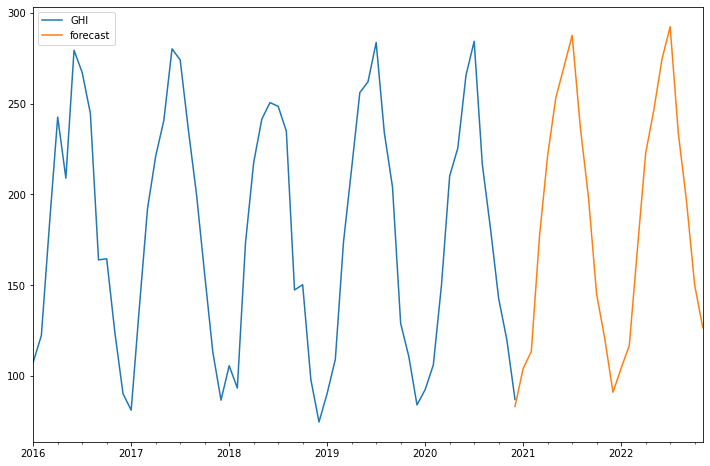

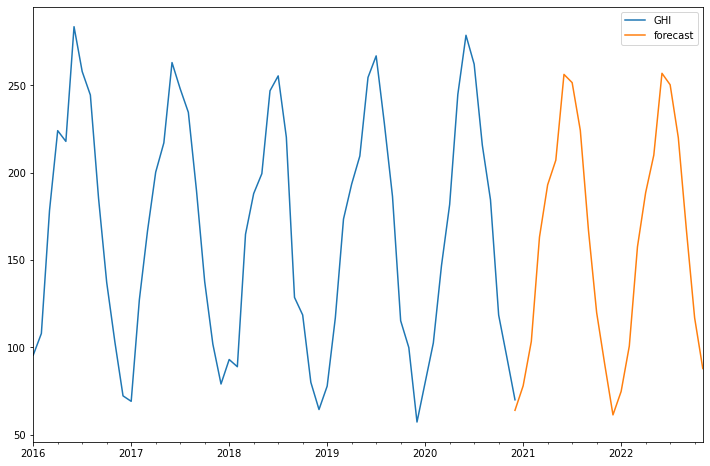

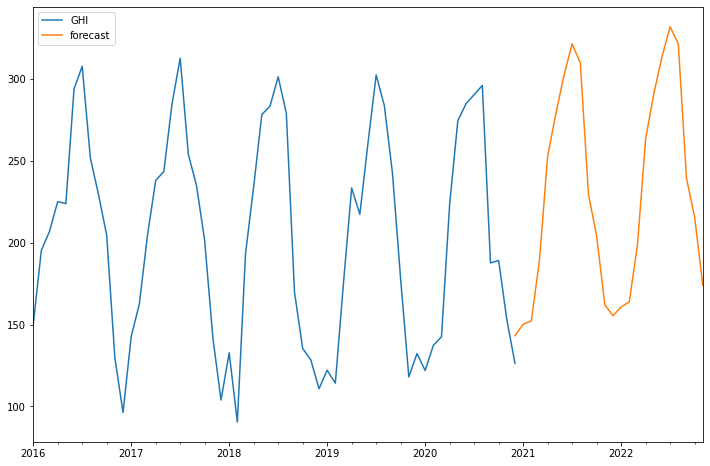

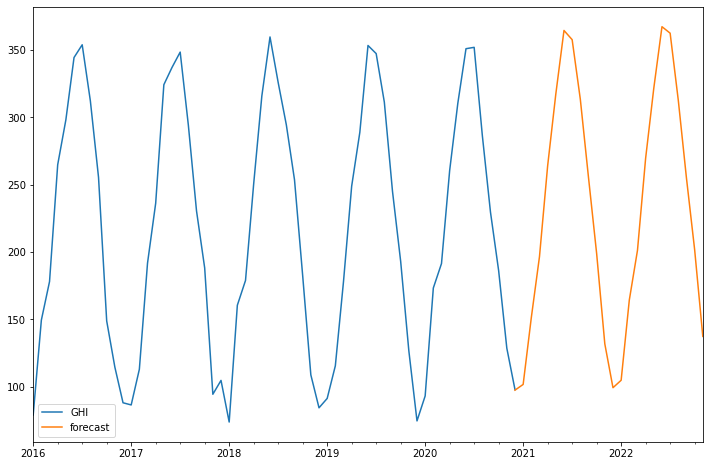

In [54]:
#All Region CSV Files
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "*.csv"))
# Read Files
for files in csv_files:
    
    data = pd.read_csv(files)
    # Drop Nan Columns
    data.dropna(axis=1,inplace=True)
    # Covert into date_time format 
    data['Date'] = pd.to_datetime(data[['Year','Month','Day','Hour','Minute']],format='%Y/%M/%D %H%m')
    # We will make a predeiction on GHI.
    data = data[['Date','GHI']]
    data.set_index('Date',inplace=True)
    #Resampling generates a unique sampling distribution on the basis of the actual data.
    #'M' = month end frequency
    data = data.resample('M').mean()
    '''
    data.plot()
    '''
    #ADF Test is a common statistical test used to test whether a given Time series is stationary or not . 
    #Testing for Stationarity
    test_result=adfuller(data)
    #Ho: It is non stationary
    #H1: It is stationary
    def adfuller_test(GHI):
        result=adfuller(GHI)
        #adfuller gives 5 different values.
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    adfuller_test(data['GHI'])
    
    data['GHI First Difference'] = data['GHI'] - data['GHI'].shift(1)
    data['Seasonal First Difference']= data['GHI'] - data['GHI'].shift(12)
    ## Again test dickey fuller test
    adfuller_test(data['Seasonal First Difference'].dropna())
    '''
    data['Seasonal First Difference'].plot()
    autocorrelation_plot(data['GHI'])
    plt.show()
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data['Seasonal First Difference'].iloc[13:],lags=22,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data['Seasonal First Difference'].iloc[13:],lags=22,ax=ax2)
    '''
    #Create SARIMAX Model
    model=sm.tsa.statespace.SARIMAX(data['GHI'],order=(1, 1, 0),seasonal_order=(1,1,1,12))
    results=model.fit()
    #Predict the data between 2019-12-31 to 2020-12-31
    data['forecast']=results.predict(start='2019-12-31',end='2020-12-31',dynamic=True)
    #data[['GHI','forecast']].plot(figsize=(12,8))
    future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]
    future_datest_data=pd.DataFrame(index=future_dates[1:],columns=data.columns)
    future_data=pd.concat([data,future_datest_data])
    future_data['forecast'] = results.predict(start = '2020-12-31', end = '2022-12-31', dynamic= True)  
    future_data[['GHI', 'forecast']].plot(figsize=(12, 8)) 

# Visualize the data: 